# Neural Trojan on traffic sign classification with CNN
Download database from https://www.kaggle.com/code/valentynsichkar/traffic-signs-classification-with-cnn/

## Understanding the database

In [61]:
import numpy as np
import pandas as pd
import pickle
import os

In [62]:
# Replace with your own database download directory
# base_path = 'E:/input'
base_path = r'C:\Users\kfrei\OneDrive - Ostbayerische Technische Hochschule Regensburg\Desktop\input'

In [63]:
from tensorflow.keras.utils import to_categorical

# Opening file for reading in binary mode
file_path = os.path.join(base_path, 'data2.pickle')
with open(file_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

print(f"{len(data)=}\n{type(data)=}\n{data.keys()=}")

data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

print(f"{data['x_train'].shape=}")
print(f"{data['x_validation'].shape=}")
print(f"{data['x_test'].shape=}")

len(data)=7
type(data)=<class 'dict'>
data.keys()=dict_keys(['y_test', 'y_validation', 'x_validation', 'x_train', 'y_train', 'labels', 'x_test'])
data['x_train'].shape=(86989, 32, 32, 3)
data['x_validation'].shape=(4410, 32, 32, 3)
data['x_test'].shape=(12630, 32, 32, 3)


In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

def convert_to_grid(x_input):
    """
    Preparing function for ploting set of examples
    As input it will take 4D tensor and convert it to the grid
    Values will be scaled to the range [0, 255]
    """

    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid

(81, 32, 32, 3)


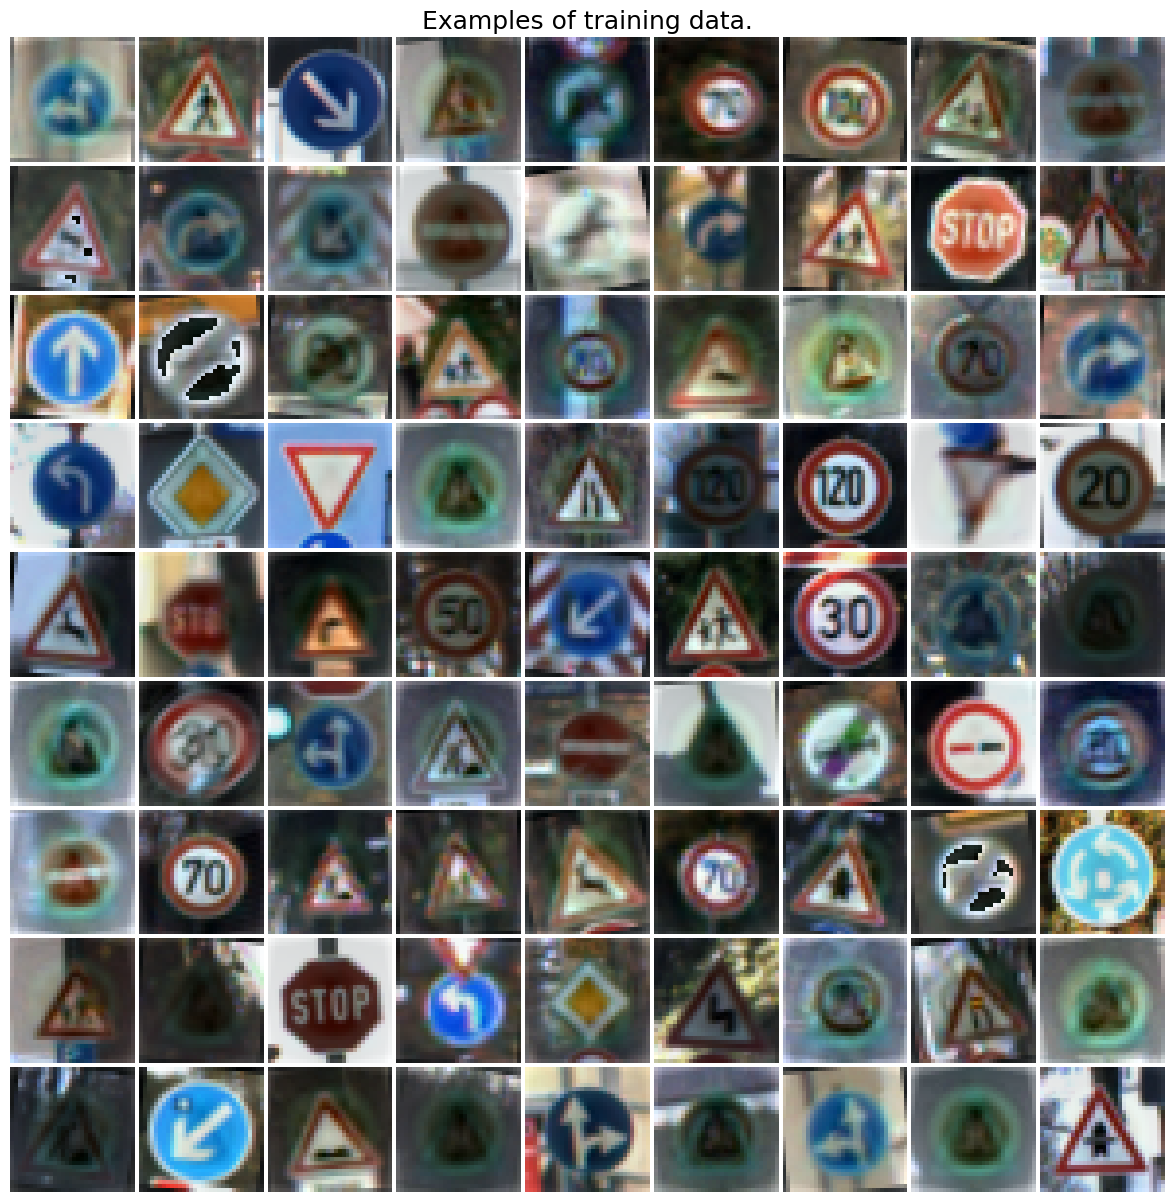

In [74]:
# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Examples of training data.', fontsize=18)
plt.show()

# Saving the plot
fig.savefig('images/training_examples.png')
plt.close()

## Building a CNN (3x3 filter)

In [66]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input

model = Sequential()

model.add(Input(shape=(32, 32, 3))) # Input as first layer
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2)) 
model.add(Flatten()) 
model.add(Dense(500, activation='relu')) 
model.add(Dense(43, activation='softmax'))  

# Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,118,939 (15.71 MB)

 Trainable params: 4,118,939 (15.71 MB)

 Non-trainable params: 0 (0.00 B)

## Training
Execution time estimation

In [67]:
import time
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
# Define the learning rate function outside the LearningRateScheduler to simplify
def scheduler(epoch, lr):
    return 1e-3 * 0.95 ** (epoch + 1)

In [69]:
epochs = 5
annealer = LearningRateScheduler(scheduler)
early_stopper = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1, mode='max', restore_best_weights=True)

h = model.fit(
    data['x_train'], data['y_train'],
    batch_size=5,
    epochs=10,
    validation_data=(data['x_validation'], data['y_validation']),
    callbacks=[annealer, early_stopper],
    verbose=0
)

model.save('model-3x3.keras')

Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.


## Testing

In [75]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('model-3x3.keras')

predictions = model.predict(data['x_test'])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = data['y_test']

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


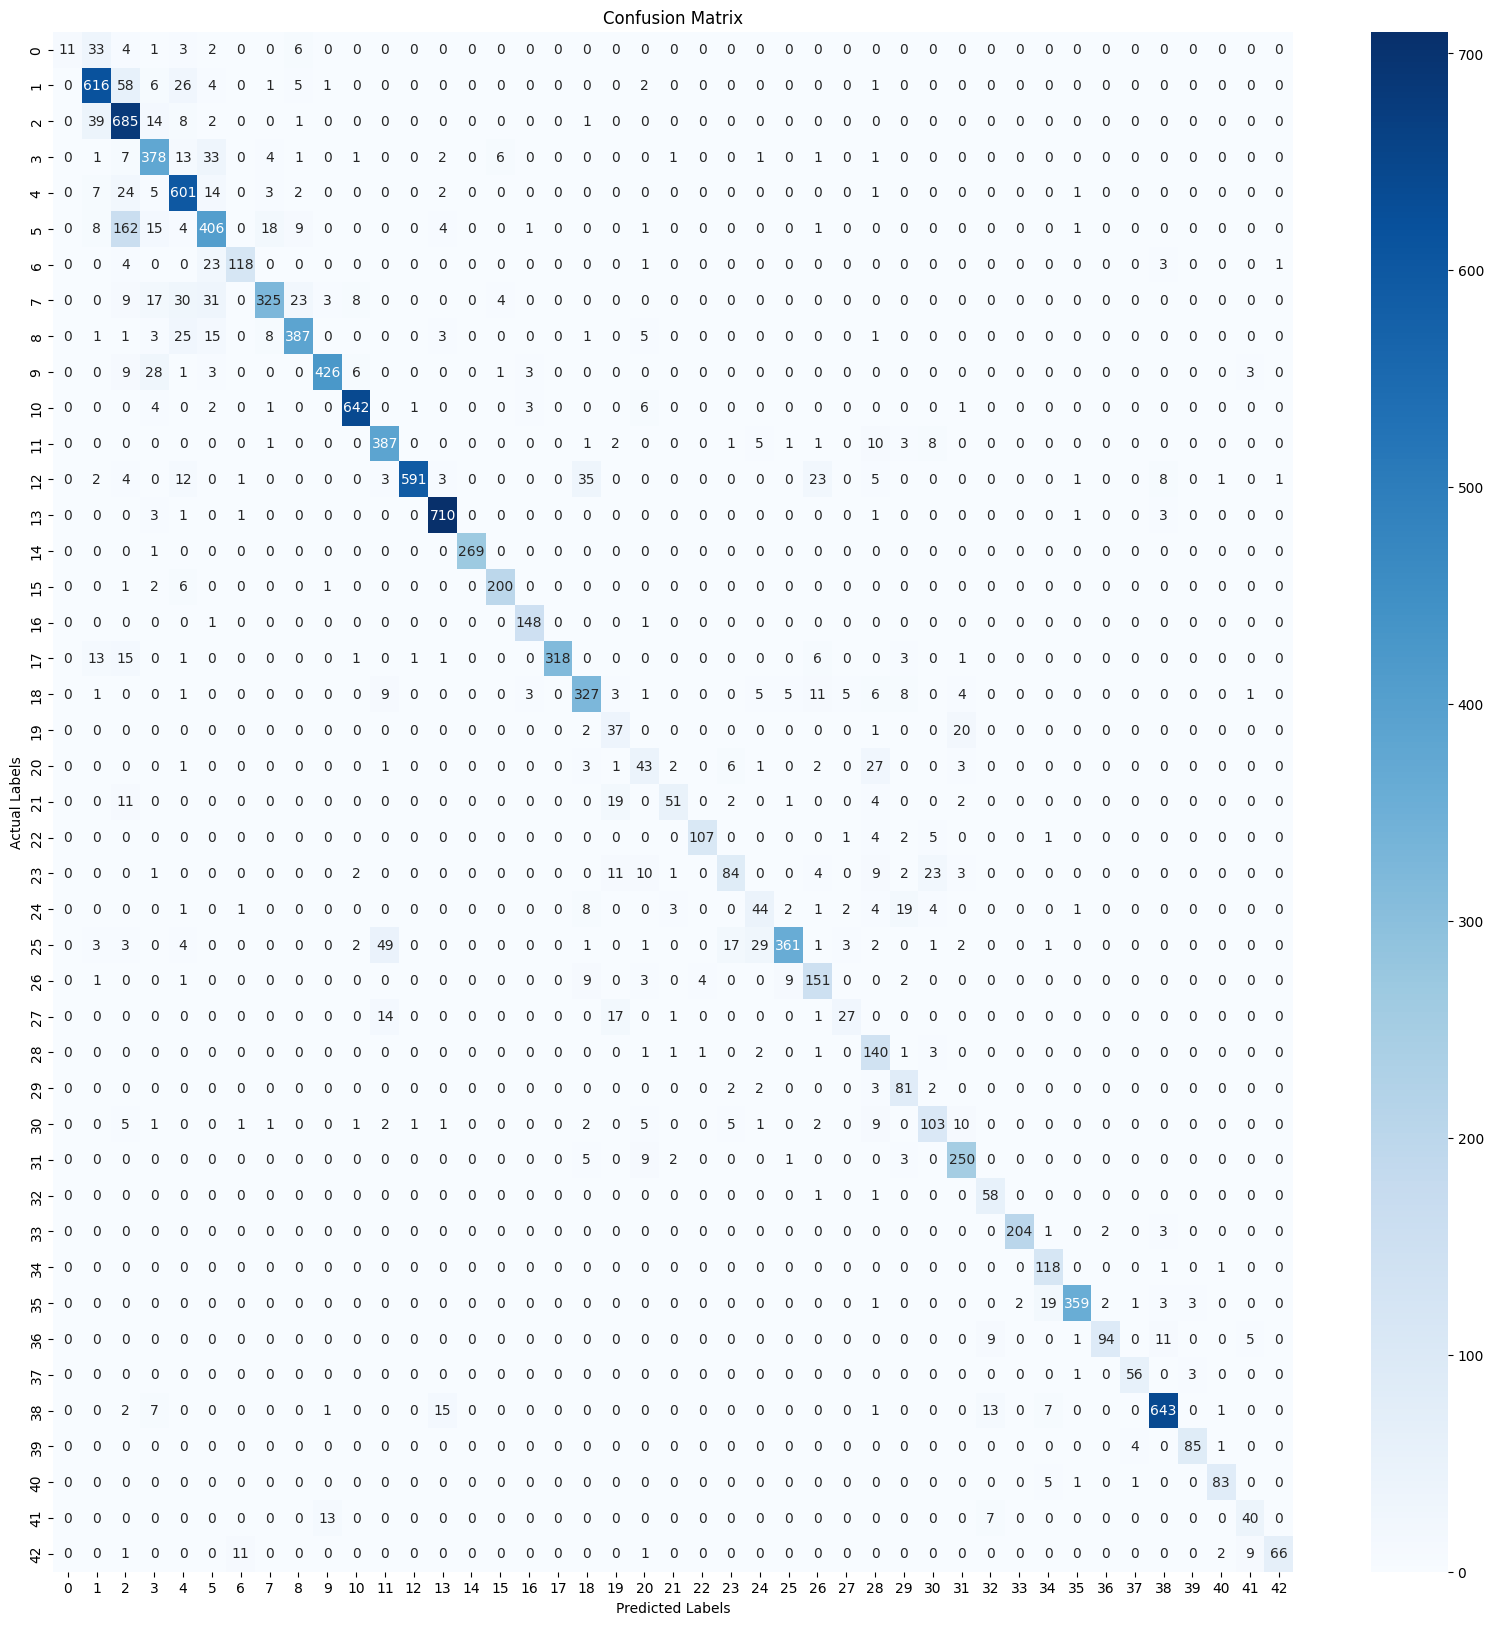

In [76]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Saving the plot
fig.savefig('images/ConfusionMatrix_validation.png')
plt.close()

In [60]:
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

print(f'{"Accuracy:":<15} {accuracy:.4f}')
print(f'{"Precision:":<15} {precision:.4f}')
print(f'{"Recall:":<15} {recall:.4f}')
print(f'{"F1 Score:":<15} {f1:.4f}')

Accuracy:       0.8347
Precision:      0.8010
Recall:         0.7943
F1 Score:       0.7888


## Prediction

In [32]:
# Extracting and loading the model we saved
import tensorflow as tf
model_path = 'model-3x3.keras'
model = tf.keras.models.load_model(model_path)
model.summary()

C:\Users\gabri\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │       4,096,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,237,880 (31.43 MB)

 Trainable params: 4,118,939 (15.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,118,941 (15.71 MB)

(1, 32, 32, 3)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


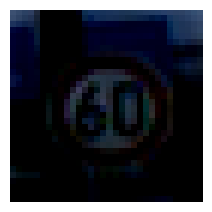

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
(43,)
ClassId: 3
Label: Speed limit (60km/h)


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = data['x_test'][100:101]
print(x_input.shape)
y_input = data['y_test'][100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
scores = model.predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    label_list = []

    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


labels = label_text(my_directory + '/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])


## Creating a Trojan

### Naive method

Pick P pixels for the trigger mask

Define the trigger (pixel pattern),

Copy R records from class K to the training dataset and poison with the trigger

Retrain the model with these records

Create a testing dataset (whose real class is not K) with the trigger previously defined

Check the accuracy. Compare to non-poisoned testing dataset. Compare results with different P and R values.